## Lucid: Cluster Predictor

绘制以下内容：
- Table 7：模型性能对比 (MAE Scores)。
- Figure 13 (a)：吞吐量预测表现。
- Figure 7 (a)(b)：模型解释和学习到的形函数。

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
from primo.model import PrimoRegressor



font_path = "/usr/share/fonts/truetype/wqy/wqy-microhei.ttc"  # Linux 示例
my_font = font_manager.FontProperties(fname=font_path)

# Matplotlib 设置
plt.rcParams['font.family'] = my_font.get_name()  # 使用指定的中文字体
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("ticks")
sns.set_context("paper", font_scale=1, rc={
    "lines.linewidth": 3,
    "lines.markersize": 10,
})
# font = {
#     "font.family": "SimHei",
#     "font.size": 12,
# }
# sns.set_style(font)
# paper_rc = {
#     "lines.linewidth": 3,
#     "lines.markersize": 10,
# }
# sns.set_context("paper", font_scale=1.8, rc=paper_rc)
# current_palette = sns.color_palette()

pd.set_option("display.max_columns", None)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


seed = 123
set_seed(seed)

cluster_list = ["Venus", "Saturn", "Philly"]
cluster = cluster_list[0]
df = pd.read_csv(
    f"../data/{cluster}/cluster_throughput.csv",
    parse_dates=["time"],
    index_col="time",
    usecols=["time", "submit_gpu_job", "submit_gpu_num"],
)
result = pd.DataFrame()

In [2]:
def soft_avg(data, t):
    avg = 0.5 * data.transform(lambda x: x.shift(t))
    avg += 0.25 * (data.transform(lambda x: x.shift(t + 1)) + data.transform(lambda x: x.shift(t - 1)))
    return avg


def rolling_data(df, item):
    if item == "submit_gpu_job":
        short = "njob"
    elif item == "submit_gpu_num":
        short = "ngpu"
    else:
        raise ValueError

    df[f"shift_1h_{short}"] = df[item].transform(lambda x: x.shift(6))  # 1 Hour Ago
    df[f"shift_3h_{short}"] = df[item].transform(lambda x: x.shift(18))  # 3 Hour Ago
    df[f"shift_1d_{short}"] = df[item].transform(lambda x: x.shift(144))  # 1 Day Ago

    df[f"soft_1h_{short}"] = soft_avg(df[item], 6)  # Soft 1 Hour Ago
    df[f"soft_3h_{short}"] = soft_avg(df[item], 18)  # Soft 3 Hour Ago
    df[f"soft_1d_{short}"] = soft_avg(df[item], 144)  # Soft 1 Day Ago

    df[f"roll_mean_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).mean())  # 1 Hour Ago
    df[f"roll_median_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).median())  # 1 Hour Ago
    df[f"roll_std_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).std())  # 1 Hour Ago

    return df


def feature_engineering(df):
    data = df.reset_index()

    """Time Features"""
    time_features = ["month", "day", "hour", "minute", "dayofweek", "dayofyear"]
    for tf in time_features:
        data[tf] = getattr(data["time"].dt, tf).astype(np.int16)
    data["week"] = data["time"].dt.isocalendar().week.astype(np.int16)  # weekofyear

    """Job Num & GPU Num Rolling"""
    data = rolling_data(data, "submit_gpu_job")
    data = rolling_data(data, "submit_gpu_num")

    return data


def plot_predict(pred, test, item, cluster, ymax=100, save=False):
    fig, ax = plt.subplots(figsize=(8, 3))
    x = np.arange(len(test))

    if "job" in item:
        str_y = "Job Submission"  # per 10 minutes"
    elif "num" in item:
        str_y = "GPU Submission"  # per 10 minutes"
    else:
        raise ValueError

    if cluster == "Philly":
        str_month = "November"
    else:
        str_month = "September"

    ax.plot(x, test[item].values, linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax.plot(x, pred, linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    ax.set_xlabel(f"Date in {str_month} ({cluster})")
    ax.set_ylabel(str_y)

    tick_interval = 2 * 144  # Two days
    ax.set_xticks(x[::tick_interval])
    ax.set_xticklabels(test["time"].dt.day[::tick_interval])
    ax.set_xlim(0, len(test) + 1)
    ax.set_ylim(0, ymax)
    ax.grid(axis="y", linestyle=":")
    ax.legend()
    sns.despine()

    if save:
        fig.savefig(f"./{cluster}_throughput_{str_y}.pdf", bbox_inches="tight")


data = feature_engineering(df)

if cluster == "Philly":
    month = 11
else:
    month = 9

train = data[data["month"] < month]
test = data[data["month"] == month]

train_data = train.iloc[:, 3:]
test_data = test.iloc[:, 3:]

train_job_label = train[["submit_gpu_job"]]
train_gpu_label = train[["submit_gpu_num"]]
test_job_label = test[["submit_gpu_job"]]
test_gpu_label = test[["submit_gpu_num"]]

train_data.fillna(value=0, inplace=True)
test_data.fillna(value=0, inplace=True)

# Plot
ymax_job = {"Saturn": 220, "Venus": 50, "Philly": 100, "Uranus": 100, "Earth": 100}
ymax_gpu = {"Saturn": 1200, "Venus": 500, "Philly": 150, "Uranus": 300, "Earth": 200}

### Interpretable Model: Primo(EBM)

In [3]:
"""Job #"""
config = {"learning_rate": 0.1, "interactions": 10}
ebm = PrimoRegressor(model="PrAM", model_config=config, hpo=None)
ebm.fit(train_data, train_job_label)
pred = ebm.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["ebm_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

# pred_df.to_csv(f"./{cluster}_throughput_pred.csv", index=False)

Dec 17 21:28:04 | Training with given model configuration. Model tuning is disabled.
Dec 17 21:28:04 | Using `PrAMRegressor` model for training.
Dec 17 21:28:04 | EBM lib loading.
Dec 17 21:28:04 | Finding library for Linux, x86_64, bitsize=64, debug=False
Dec 17 21:28:04 | Loading EBM library /home/lrm/anaconda3/envs/lucid/lib/python3.9/site-packages/interpret/utils/../root/bld/lib/libebm_linux_x64.so
Dec 17 21:28:04 | Creating native dataset
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | eval_terms
Dec 17 21:28:12 | Creating native dataset
Dec 17 21:28:12 | Estimating with FAST
Dec 17 21:28:16 | eval_terms
Dec 17 21:28:16 | eval_terms


mae_score: 4.12, r2_score: 0.1203


### Baselines

1. LightGBM

In [4]:
"""Job #"""
model = lgb.LGBMRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["lgb_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 22032, number of used features: 25
[LightGBM] [Info] Start training from score 4.521514
mae_score: 4.45, r2_score: 0.0727


2. XGBoost

In [5]:
"""Job #"""
model = xgb.XGBRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["xgb_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

mae_score: 5.24, r2_score: -0.1196


3. Random Forest

In [6]:
"""Job #"""
model = RandomForestRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["rf_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

/home/lrm/anaconda3/envs/lucid/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mae_score: 4.52, r2_score: 0.1075


4. DNN

In [7]:
"""Job #"""
model = MLPRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["dnn_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

/home/lrm/anaconda3/envs/lucid/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mae_score: 5.27, r2_score: -3.3059


## Result Comparison

In [8]:
result

,Venus
ebm_job_mae,4.121578
lgb_job_mae,4.452982
xgb_job_mae,5.243026
rf_job_mae,4.520208
dnn_job_mae,5.268656


# Prediction Visualization

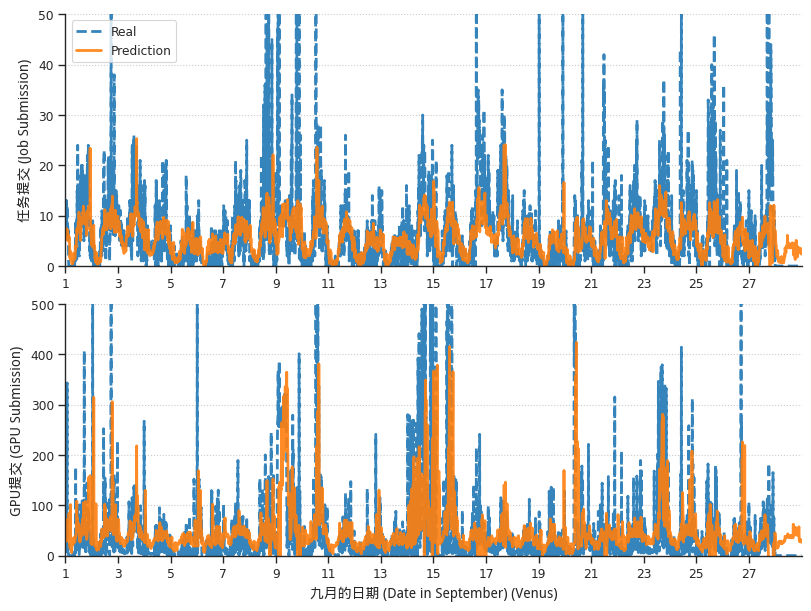

In [9]:
def plot_predict_all(df, cluster, ymax_job, ymax_gpu, save=False):
    fig, (ax1, ax2) = plt.subplots(
        ncols=1, nrows=2, constrained_layout=True, figsize=(8, 6)
    )
    x = np.arange(len(df))
    df.reset_index()

    if cluster == "Philly":
        str_month = "November"
    else:
        str_month = "September"

    ax1.plot(x, df["submit_gpu_job"], linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax1.plot(x, df["pred_gpu_job"], linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    # ax1.set_xlabel(f"Date in {str_month} ({cluster})")
    ax1.set_ylabel("任务提交 (Job Submission)", fontproperties=my_font)

    tick_interval = 2 * 144  # Two days
    ax1.set_xticks(x[::tick_interval])
    ax1.set_xticklabels(df.index.day[::tick_interval])
    ax1.set_xlim(0, len(df) + 1)
    ax1.set_ylim(0, ymax_job[cluster])
    ax1.grid(axis="y", linestyle=":")
    ax1.legend()

    ax2.plot(x, df["submit_gpu_num"], linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax2.plot(x, df["pred_gpu_num"], linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    ax2.set_xlabel(f"九月的日期 (Date in {str_month}) ({cluster})", fontproperties=my_font)
    ax2.set_ylabel("GPU提交 (GPU Submission)", fontproperties=my_font)

    ax2.set_xticks(x[::tick_interval])
    ax2.set_xticklabels(df.index.day[::tick_interval])
    ax2.set_xlim(0, len(df) + 1)
    ax2.set_ylim(0, ymax_gpu[cluster])
    ax2.grid(axis="y", linestyle=":")

    sns.despine()

    if save:
        fig.savefig(f"./{cluster}_throughput.pdf", bbox_inches="tight")

pred_df = pd.read_csv(f"./{cluster}_throughput_pred.csv", parse_dates=["time"], index_col="time")

plot_predict_all(pred_df, cluster, ymax_job, ymax_gpu, save=True)


# Model Interpretation

In [10]:
ebm_ = ebm.prModel.gam

# 使用explain_global()来获取全局解释
global_explanation = ebm_.explain_global()

name = global_explanation.data()['names']
print(name)
feature_score = ebm_.explain_global().data()['scores']
print(feature_score)

sorted_score = sorted(feature_score, reverse=True)
sort_idx = sorted(range(len(feature_score)), key= lambda x: feature_score[x],reverse=True)
sorted_feature = [ebm_.explain_global().data()['names'][i] for i in sort_idx]

sorted_feature = [i.replace("_ngpu", "") for i in sorted_feature]

['month', 'day', 'hour', 'minute', 'dayofweek', 'dayofyear', 'week', 'shift_1h_njob', 'shift_3h_njob', 'shift_1d_njob', 'soft_1h_njob', 'soft_3h_njob', 'soft_1d_njob', 'roll_mean_1h_njob', 'roll_median_1h_njob', 'roll_std_1h_njob', 'shift_1h_ngpu', 'shift_3h_ngpu', 'shift_1d_ngpu', 'soft_1h_ngpu', 'soft_3h_ngpu', 'soft_1d_ngpu', 'roll_mean_1h_ngpu', 'roll_median_1h_ngpu', 'roll_std_1h_ngpu', 'hour & soft_1h_njob', 'hour & roll_mean_1h_njob', 'soft_1h_njob & roll_median_1h_njob', 'soft_1h_njob & roll_median_1h_ngpu', 'roll_mean_1h_njob & roll_median_1h_njob', 'roll_mean_1h_njob & roll_median_1h_ngpu', 'roll_median_1h_njob & roll_std_1h_njob', 'roll_median_1h_njob & roll_mean_1h_ngpu', 'roll_std_1h_njob & roll_median_1h_ngpu', 'roll_mean_1h_ngpu & roll_median_1h_ngpu']
[np.float64(0.08668763268880396), np.float64(0.11723941283900749), np.float64(0.8561865226890757), np.float64(0.0373411914278096), np.float64(0.28607037488483167), np.float64(0.07888366929563803), np.float64(0.139612481672

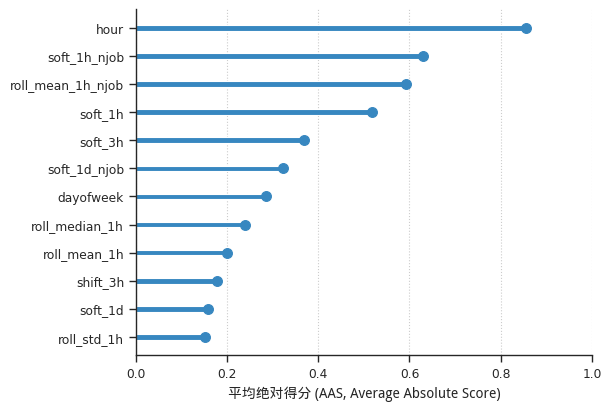

In [11]:
cmp = sns.color_palette("tab10")
cmp1 = sns.color_palette("Blues",8)
def global_interpret(n_features=12, save=False):
    fig, ax = plt.subplots(
        ncols=1, nrows=1, constrained_layout=True, figsize=(6, 4)
    )
    
    n_features = n_features
    x = np.arange(1, n_features+1)

    ax.barh(x[::-1], sorted_score[:n_features], label=sorted_feature[:n_features], height=0.2, color=cmp1[5])
    ax.scatter(sorted_score[:n_features], x[::-1], s=50, color=cmp1[5])
    
    ax.set_xlim(0, 1)
    ax.set_yticks(x)
    ax.set_yticklabels(sorted_feature[:n_features][::-1])
    ax.set_xlabel(f"平均绝对得分 (AAS, Average Absolute Score)", fontproperties=my_font)
    ax.grid(axis="x", linestyle=":")
    sns.despine()

    if save:
        fig.savefig(f"./interpret_{cluster}_throughput.pdf", bbox_inches="tight")


global_interpret(n_features=12, save=True)

In [12]:
from sklearn.isotonic import IsotonicRegression

feature_index = 2
# 获取全局解释
global_explanation = ebm_.explain_global()

# 提取特定特征的信息
feature_data = global_explanation.data(feature_index)
# print(feature_data.keys())
# print(feature_data)


# 获取分箱的索引 (x)、分箱的分数 (y) 和权重 (sample_weight)
x = np.array(range(len(feature_data['scores'])))  # 分箱的索引
y = np.array(feature_data['scores'])  # 分箱对应的得分
# w = np.array(feature_data['density'])  # 分箱对应的样本权重（或密度）

# TODO 密度权重不一致
# w = feature_data['density']['scores'] # 分箱对应的样本权重（或密度）


# print(len(x))
# print(len(y))
# print(len(w))
# print(len(w))

# 使用 IsotonicRegression 拟合
direction = "auto"
ir = IsotonicRegression(out_of_bounds="clip", increasing=direction)

# # 输出结果
# print("Original Scores (y):", y)
# print("Fitted Scores (y_):", y_)

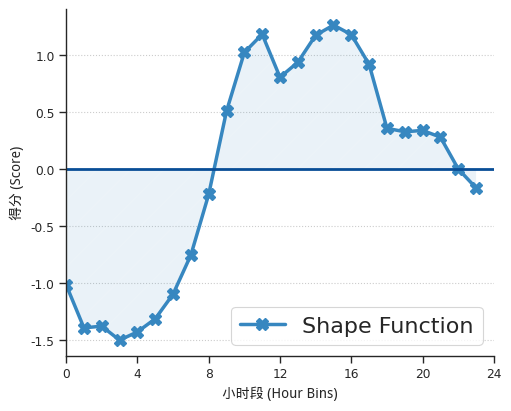

In [13]:
def hour_interpret(save=False):
    fig, ax = plt.subplots(
        ncols=1, nrows=1, constrained_layout=True, figsize=(5, 4)
    )
    y2 = 0
    ax.plot(x, y, '-', label="Shape Function", marker="X", markersize=8, linewidth=2.5, color=cmp1[5], alpha=1)

    ax.set_xlabel("小时段 (Hour Bins)", fontproperties=my_font)
    ax.set_ylabel(f"得分 (Score)", fontproperties=my_font)
    ax.set_xlim(0, 24)
    ax.set_xticks([0, 4, 8, 12, 16, 20, 24])
    # ax.set_ylim(-1.5, 4)
    sns.despine()

    ax.grid(axis="y", linestyle=":")
    ax.axhline(y=0, c=cmp1[-1], linewidth=2)
    ax.fill_between(x, y, y2, facecolor=cmp1[5], alpha = 0.1, hatch='/')
    ax.legend(loc=0, fontsize=16)

    if save:
        fig.savefig(f"./interpret_{cluster}_shapefunc.pdf", bbox_inches="tight")


hour_interpret(save=True)